In [2]:
from gensim.models import Word2Vec, FastText
import parsivar
import json
import pickle
import itertools
import functools
import seaborn as sns
import random
import numpy as np
import pandas as pd
import editdistance
from polyleven import levenshtein
import time
import threading
import multiprocessing


In [3]:
normalizer = parsivar.Normalizer()
tokenizer = parsivar.Tokenizer()
if __name__ == '__main__':
    manager = multiprocessing.Manager()

# load data

In [3]:
f = open("test.txt", "r", encoding='utf-8')
number_of_chars = len(f.read())
print(f'{number_of_chars} characters')
f.close()
f = open("test.txt", "r", encoding='utf-8')
number_of_lines = len(f.readlines())
print(f'{number_of_lines} lines')
f.close()

254885725 characters
2233985 lines


In [6]:
def get_sentences():
    sentences = []
    with open("test.txt", "r", encoding='utf-8') as t:
        while True:
            line = t.readline()
            if line == "":
                break
            sentences.append(tokenizer.tokenize_words(line))
    return sentences

In [7]:
%%time
sentences = get_sentences()
# print(len(sentences))
# 4GB of RAM

Wall time: 23.8 s


# fastText model

In [4]:
FastText_model = FastText.load("FastTextModel")
# 3.5GB RAM

In [9]:
%%time
FastText_model = FastText(vector_size=300, window=5, min_count=1, sentences=sentences, epochs=5)

Wall time: 16min 33s


In [10]:
FastText_model.wv.most_similar(FastText_model.wv['شاه'])

[('شاه', 1.0000001192092896),
 ('شاهنشاه', 0.9176587462425232),
 ('شاهق', 0.8465709686279297),
 ('رضاشاه', 0.826755940914154),
 ('نوذرشاه', 0.820631206035614),
 ('شاهرگش', 0.8145061135292053),
 ('شاهو', 0.8129557371139526),
 ('شاه\u200cکش', 0.8070375919342041),
 ('ملکشاه', 0.8045138716697693),
 ('رضا\u200cشاه', 0.8026924729347229)]

In [11]:
FastText_model.save("FastTextModel")

# Word2Vec model

In [5]:
word2vec_model = Word2Vec.load("Word2VecModel")
# 1GB RAM

In [12]:
%%time
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=1, sentences=sentences, epochs=5)

Wall time: 4min 17s


In [13]:
word2vec_model.wv.most_similar(word2vec_model.wv['مرد'], topn=10)

[('مرد', 1.0000001192092896),
 ('زن', 0.6612441539764404),
 ('مردی', 0.6590302586555481),
 ('شوهر', 0.6402674317359924),
 ('پیرزن', 0.6143919229507446),
 ('دختری', 0.6141065359115601),
 ('میانسال', 0.6090303063392639),
 ('پیرمرد', 0.5989894866943359),
 ('دختر', 0.5964543223381042),
 ('شوهری', 0.5797011852264404)]

In [14]:
word2vec_model.wv.distance("شاه", "ملکه")

0.5490146577358246

In [15]:
word2vec_model.save("Word2VecModel")

# load Ngram Model

In [6]:
def words_to_tuple(words, model):
    return tuple([model.wv.key_to_index[words[i]] for i in range(len(words))])

# seems some of the words in the text file is not present in model key_to_index
def build_ngrams(n):
    ngram_counts = {}
    with open("test.txt", "r", encoding='utf-8') as t:
        while True:
            line = t.readline()
            if line == "":
                break
            words = tokenizer.tokenize_words(line)
            for i in range(max(len(words)-n+1, 0)):
                try:
#                     pre_words_indices = tuple([word2vec_model.wv.key_to_index[words[i+j]] for j in range(n)])
                    pre_words_indices = words_to_tuple(words[i:i+n], word2vec_model)
                    if pre_words_indices in ngram_counts:
                        ngram_counts[pre_words_indices] += 1
                    else:
                        ngram_counts[pre_words_indices] = 1
                except:
                    pass
    return ngram_counts

In [7]:
%%time
word_counts = build_ngrams(1)
word_counts["all"] = sum(word_counts.values())
print("words counts: ", word_counts["all"])
# 100MB of RAM
biword_counts = build_ngrams(2)
biword_counts["all"] = sum(biword_counts.values())
print("biword counts: ", biword_counts["all"])

# 700MB of RAM
threeword_counts = build_ngrams(3)
threeword_counts["all"] = sum(threeword_counts.values())
print("threeword counts: ", threeword_counts["all"])
# 1.6GB of RAM
fourword_counts = build_ngrams(4)
fourword_counts["all"] = sum(fourword_counts.values())
# 3.5GB of RAM

words counts:  46121508
biword counts:  44205666
threeword counts:  42326267
Wall time: 5min 58s


In [8]:
with open('word counts.json', 'wb') as f:
    pickle.dump(word_counts, f)
with open('bi-grams.json', 'wb') as f:
    pickle.dump(biword_counts, f)
with open('three-grams.json', 'wb') as f:
    pickle.dump(threeword_counts, f)
with open('four-grams.json', 'wb') as f:
    pickle.dump(fourword_counts, f)

In [18]:
print(f'words:       {len(word_counts)}')
print(f'bi-grams:    {len(biword_counts)}')
print(f'three-grams: {len(threeword_counts)}')
print(f'four-grams:  {len(fourword_counts)}')

words:       347680
bi-grams:    6764724
three-grams: 20208193
four-grams:  29157652


In [5]:
with open('word counts.json', 'rb') as f:
    word_counts = pickle.load(f)
    f.close()
with open('bi-grams.json', 'rb') as f:
    biword_counts = pickle.load(f)
    f.close()
with open('three-grams.json', 'rb') as f:
    threeword_counts = pickle.load(f)
    f.close()
# with open('four-grams.json', 'rb') as f:
#     fourword_counts = pickle.load(f)
#     f.close()

In [17]:
stop_words = [[word2vec_model.wv.index_to_key[x[0][0]], word2vec_model.wv.index_to_key[x[0][1]]] for x in sorted(biword_counts.items(), key = lambda x: x[1], reverse=True)[800:1000]]
stop_words

[['در', 'جنگ'],
 ['خمینی', 'ره'],
 ['از', 'مشکلات'],
 ['در', 'واکنش'],
 ['و', 'او'],
 ['می\u200cتوان', 'به'],
 ['در', 'راه'],
 ['کل', 'کشور'],
 ['رسید', 'و'],
 ['برای', 'آن'],
 ['پایان', 'سال'],
 ['البته', 'این'],
 ['و', 'درصد'],
 ['در', 'تمام'],
 ['حمله', 'به'],
 ['ادامه', 'می\u200cدهد'],
 ['هر', 'چه'],
 ['قاسم', 'سلیمانی'],
 ['میلیارد', 'ریال'],
 ['حسن', 'روحانی'],
 ['اینکه', 'این'],
 ['دونالد', 'ترامپ'],
 ['در', 'رابطه'],
 ['با', 'آمریکا'],
 ['به', 'سوی'],
 ['تا', 'درصد'],
 ['بر', 'روی'],
 ['که', 'آیا'],
 ['ایران', 'برای'],
 ['من', 'در'],
 ['گفت', 'با'],
 ['با', 'انتشار'],
 ['و', 'می\u200cگوید'],
 ['مبتنی', 'بر'],
 ['شوند', 'و'],
 ['که', 'آن\u200cها'],
 ['دانست', 'و'],
 ['همراه', 'با'],
 ['یادآور', 'شد'],
 ['شهر', 'و'],
 ['به', 'میلیون'],
 ['از', 'آنجا'],
 ['جام', 'جهانی'],
 ['کرده\u200cاند', 'که'],
 ['و', 'مشکلات'],
 ['استان', 'تهران'],
 ['آن', 'از'],
 ['به\u200cعنوان', 'یک'],
 ['دارد', 'اما'],
 ['ما', 'این'],
 ['لازم', 'برای'],
 ['که', 'پس'],
 ['و', 'بودجه'],
 ['و', 'ایجاد'],
 ['ک

In [15]:
stop_words = [[word2vec_model.wv.index_to_key[x[0][0]], word2vec_model.wv.index_to_key[x[0][1]], word2vec_model.wv.index_to_key[x[0][2]]] 
              for x in sorted(threeword_counts.items(), key = lambda x: x[1], reverse=True)[300:800]]
stop_words

[['مورد', 'بررسی', 'قرار'],
 ['و', 'از', 'آن'],
 ['کرونا', 'در', 'کشور'],
 ['در', 'خارج', 'از'],
 ['مبتلا', 'به', 'کووید'],
 ['در', 'این', 'صورت'],
 ['که', 'منجر', 'به'],
 ['ماه', 'مبارک', 'رمضان'],
 ['شد', 'و', 'به'],
 ['هر', 'یک', 'از'],
 ['در', 'این', 'بین'],
 ['برگزار', 'خواهد', 'شد'],
 ['بعد', 'از', 'این'],
 ['رعایت', 'پروتکل\u200cهای', 'بهداشتی'],
 ['در', 'شرایط', 'فعلی'],
 ['داشته', 'باشند', 'و'],
 ['است', 'که', 'دولت'],
 ['در', 'روزهای', 'اخیر'],
 ['پس', 'از', 'این'],
 ['صنعت', 'معدن', 'و'],
 ['حال', 'انجام', 'است'],
 ['کسب', 'و', 'کار'],
 ['در', 'شهر', 'تهران'],
 ['دولت', 'تدبیر', 'و'],
 ['و', 'این', 'موضوع'],
 ['ورزش', 'و', 'جوانان'],
 ['معدن', 'و', 'تجارت'],
 ['گفت\u200cوگو', 'با', 'خبرگزاری'],
 ['در', 'همین', 'زمینه'],
 ['مجمع', 'تشخیص', 'مصلحت'],
 ['پاسخ', 'به', 'سوالی'],
 ['داخلی', 'و', 'خارجی'],
 ['است', 'و', 'اگر'],
 ['در', 'سال', 'در'],
 ['به', 'هیچ', 'عنوان'],
 ['با', 'این', 'وجود'],
 ['مردم', 'را', 'به'],
 ['و', 'در', 'حال'],
 ['که', 'برخی', 'از'],
 ['انقلاب', 'اسلام

In [18]:
stop_words = [[word2vec_model.wv.index_to_key[x[0][0]], word2vec_model.wv.index_to_key[x[0][1]], word2vec_model.wv.index_to_key[x[0][2]], word2vec_model.wv.index_to_key[x[0][3]]] 
              for x in sorted(fourword_counts.items(), key = lambda x: x[1], reverse=True)[400:800]]
stop_words

[['وزارت', 'تعاون', 'کار', 'و'],
 ['پس', 'از', 'پیروزی', 'انقلاب'],
 ['دونالد', 'ترامپ', 'رییس\u200cجمهور', 'آمریکا'],
 ['رییس\u200cجمهور', 'با', 'بیان', 'اینکه'],
 ['حضرت', 'آیت\u200cالله', 'العظمی', 'خامنه\u200cای'],
 ['در', 'دوران', 'دفاع', 'مقدس'],
 ['او', 'در', 'پاسخ', 'به'],
 ['بیش', 'از', 'میلیون', 'نفر'],
 ['از', 'شیوع', 'ویروس', 'کرونا'],
 ['در', 'این', 'دوره', 'از'],
 ['کرد', 'و', 'گفت', 'در'],
 ['به', 'بیش', 'از', 'هزار'],
 ['رییس\u200cجمهور', 'با', 'اشاره', 'به'],
 ['از', 'دست', 'داده', 'و'],
 ['وزارت', 'راه', 'و', 'شهر\u200cسازی'],
 ['به', 'کووید', 'در', 'بخش\u200cهای'],
 ['و', 'هزار', 'و', 'دز'],
 ['به', 'گزارش', 'خبرگزاری', 'صداوسیما'],
 ['کووید', 'در', 'بخش\u200cهای', 'مراقبت\u200cهای'],
 ['که', 'در', 'سال', 'گذشته'],
 ['دیروز', 'مجلس', 'شورای', 'اسلامی'],
 ['است', 'که', 'بسیاری', 'از'],
 ['سه', 'میلیون', 'و', 'هزار'],
 ['به', 'نقل', 'از', 'منابع'],
 ['هزار', 'میلیارد', 'تومان', 'در'],
 ['ساعت', '-', 'شبکه', 'ورزش'],
 ['از', 'سوی', 'دیگر', 'با'],
 ['در', 'این', 'مراسم',

# define spell checker

In [8]:
character_neighbors = {
    "ض" : ["ص", "ظ", "ز", "ذ"],
    "ص" : ["ض", "ث"],
    "ث" : ["ص", "ق"],
    "ق" : ["ف", "ث", "غ"],
    "ف" : ["ق", "غ"],
    "غ" : ["ف", "ه", "ق"],
    "ع" : ["غ", "ه"],
    "ه" : ["ع", "خ", "ح"],
    "خ" : ["ه", "ح"],
    "ح" : ["خ", "ج", "ه"],
    "ج" : ["ح", "چ"],
    "چ" : ["ج", "پ"],
    "پ" : ["چ", "ب"],
    "ش" : ["س"],
    "س" : ["ش", "ی"],
    "ی" : ["س", "ب"],
    "ب" : ["ی", "ل"],
    "ل" : ["ب", "ا", "آ"],
    "ا" : ["ل", "ت"],
    "آ" : ["ل", "ت"],
    "ت" : ["ا", "ن", "ط", "آ"],
    "ن" : ["ت", "م"],
    "م" : ["ن", "ک"],
    "ک" : ["م", "گ"],
    "گ" : ["ک"],
    "ظ" : ["ط", "ض", "ز", "ذ"],
    "ط" : ["ظ", "ز", "ت"],
    "ز" : ["ط", "ض", "ر", "ذ"],
    "ژ" : ["ط", "ر"],
    "ر" : ["ز", "ذ"],
    "ذ" : ["ر", "ض", "د", "ذ"],
    "د" : ["ذ", "ی"],
    "و" : ["د"],
}

In [9]:
replaceble_characters = list(character_neighbors.keys())

In [10]:
def edit_distance(word, proposed_word, m, n, distance=0, max_distance=2, changes=[]):
    if m == 0:
        return n
    if n == 0:
        return m
    if word[m-1] == proposed_word[n-1]:
        return edit_distance(word, proposed_word, m-1, n-1, distance, max_distance)
    else:
        if distance == max_distance:
            return max_distance+1
        return 1+(min(edit_distance(word, proposed_word, m,   n-1, distance+1, max_distance), 
                      edit_distance(word, proposed_word, m-1, n,   distance+1, max_distance),
                      edit_distance(word, proposed_word, m-1, n-1, distance+1, max_distance)))

In [11]:
class spellChecker:
    def __init__(self, model, word_counts, biword_counts, threeword_counts, fourword_counts, 
                 candidate_count_tresh=50, candidate_sim_tresh = 0.6, ngram_weights=[1, 1, 1], 
                 max_editdistance=2, close_extra_char_penalty = 0.1, far_extra_char_penalty = 0.001, 
                 missed_char_penalty = 0.01, close_replace_char_penalty = 0.1, far_replace_char_penalty = 0.001):
        self.model = model
        self.word_counts = word_counts
        self.biword_counts = biword_counts
        self.threeword_counts = threeword_counts
        self.fourword_counts = fourword_counts
        self.candidate_count_tresh = candidate_count_tresh
        self.candidate_sim_tresh = candidate_sim_tresh
        
        self.ngram_weights = np.array(ngram_weights)
        self.max_editdistance = max_editdistance
        
        self.close_extra_char_penalty = close_extra_char_penalty
        self.far_extra_char_penalty = far_extra_char_penalty
        self.missed_char_penalty = missed_char_penalty
#         self.close_extra_char_penalty = 0.1
        self.close_replace_char_penalty = close_replace_char_penalty
        self.far_replace_char_penalty = far_replace_char_penalty
        
    
    def cal_proposed_word_penalty(self, word, proposed_word, m=0, n=0):
        distance = levenshtein(word, proposed_word)
        
        return 0.01**distance
        
        if m == len(word):
            if n == len(proposed_word):
                return 1
            x = [self.close_extra_char_penalty if proposed_word[i] in  character_neighbors.get(proposed_word[i-1], []) else 
                 self.far_extra_char_penalty for i in range(n, len(proposed_word))]
            return np.prod(x)

        if n == len(proposed_word):
#             if m == len(word):
#                 return 1
            return self.missed_char_penalty**(len(word)-m)

        if word[m] == proposed_word[n]:
            return self.cal_proposed_word_penalty(word, proposed_word, m+1, n+1)

        neighbors = character_neighbors.get(proposed_word[n], [])

        if (n >= 1 and proposed_word[n-1] in neighbors) or (n <= len(proposed_word)-2 and proposed_word[n+1] in neighbors):
            addition_cost = self.close_extra_char_penalty
        else:
            addition_cost = self.far_extra_char_penalty

        if word[m] in neighbors:
            replace_cost = self.close_replace_char_penalty
        else:
            replace_cost = self.far_replace_char_penalty

        return (max(addition_cost*self.cal_proposed_word_penalty(word, proposed_word, m,   n+1),     # delete letter
                    self.missed_char_penalty*self.cal_proposed_word_penalty(word, proposed_word, m+1, n),       # add letter
                    replace_cost* self.cal_proposed_word_penalty(word, proposed_word, m+1, n+1)))    # replace letter
    
    def check_if_need_replacement(self, query_words, context):
        res = []
        count_threshold = 2
        word_in_vocab = [x in self.model.wv.key_to_index for x in query_words]
        if len(query_words) == 1:
            return [not word_in_vocab[0]]
            
        for i in range(len(query_words)):
            
            if not word_in_vocab[i] or self.model.wv.cosine_similarities(
                               self.model.wv[query_words[i]], context) < self.candidate_sim_tresh:
                res.append(True)
                continue
#             if not word_in_vocab:
#                 res.append(True)
#             elif i > 0 and i < len(query_words)-1 and (
#                 self.biword_counts.get((self.model.wv.key_to_index.get(query_words[i-1], None), 
#                                         self.model.wv.key_to_index.get(query_words[i], None), 0)) <= count_threshold and
#                 self.biword_counts.get((self.model.wv.key_to_index.get(query_words[i], None), 
#                                         self.model.wv.key_to_index.get(query_words[i+1], None), 0)) <= count_threshold):
#                 res.append(True)
#             elif i == 0 and self.biword_counts.get((self.model.wv.key_to_index.get(query_words[i], None), 
#                                                     self.model.wv.key_to_index.get(query_words[i+1], None)), 0) <= count_threshold:
#                 res.append(True)
#             elif self.biword_counts.get((self.model.wv.key_to_index.get(query_words[i-1], None), 
#                                          self.model.wv.key_to_index.get(query_words[i], None)), 0) <= count_threshold:
#                 res.append(True)
            else:
                res.append(False)
        return res
            
    def merge_candidates(self, res, index):
        a = res.pop(index)
        b = res.pop(index)
        if not a or not b:
            res.insert(index, [])
        elif len(a[0]) == 1 and len(b[0]) == 1:
            res.insert(index, [x + y for x in a for y in b if 
                                self.biword_counts.get((self.model.wv.key_to_index.get(x[0], None), 
                                                       self.model.wv.key_to_index.get(y[0], None)), 0) >= 1])
        elif len(a[0]) == 1:
            res.insert(index, [x + y for x in a for y in b if 
                                self.threeword_counts.get((self.model.wv.key_to_index.get(x[0], None), 
                                                           self.model.wv.key_to_index.get(y[0], None),
                                                           self.model.wv.key_to_index.get(y[1], None)), 0) >= 1]) 
        elif len(b[0]) == 1:
            res.insert(index, [x + y for x in a for y in b if 
                                self.threeword_counts.get((self.model.wv.key_to_index.get(x[-2], None), 
                                                           self.model.wv.key_to_index.get(x[-1], None),
                                                           self.model.wv.key_to_index.get(y[0], None)), 0) >= 1]) 
        else:
            res.insert(index, [x + y for x in a for y in b if 
                                self.threeword_counts.get((self.model.wv.key_to_index.get(x[-2], None), 
                                                           self.model.wv.key_to_index.get(x[-1], None),
                                                           self.model.wv.key_to_index.get(y[0], None)), 0) >= 1 and 
                                self.threeword_counts.get((self.model.wv.key_to_index.get(x[-1], None), 
                                                           self.model.wv.key_to_index.get(y[0], None),
                                                           self.model.wv.key_to_index.get(y[1], None)), 0) >= 1])

    def cal_phrase_candidates(self, word_candidates, query_words, save_time=False):
        t = []
        l = []
        t.append(time.time())
        if len(word_candidates) == 1:
            return [[x] for x in word_candidates[0]]
        res = [[x] for x in word_candidates[0]]
        
        t.append(time.time())
        l.append(len(res))
        
        res = [x+[y] for x in res for y in word_candidates[1] if 
                   self.biword_counts.get((self.model.wv.key_to_index.get(x[-1], None), 
                                           self.model.wv.key_to_index.get(y, None)), 0) >= 1]
        if save_time == True:
                if len(res) > 50000:
                    return None
        t.append(time.time())
        l.append(len(res))
        
        for i in range(2, len(word_candidates)):
            
            res = [x+[y] for x in res for y in word_candidates[i] if 
                   self.threeword_counts.get((self.model.wv.key_to_index.get(x[-2], None), 
                                          self.model.wv.key_to_index.get(x[-1], None),
                                          self.model.wv.key_to_index.get(y, None)), 0) >= 1]
            if save_time == True:
                if len(res) > 50000:
                    return None
            t.append(time.time())
            l.append(len(res))
        
#         for i in range(1, len(word_candidates)):
#             res = [x+[y] for x in res for y in word_candidates[i] if 
#                    self.biword_counts.get((self.model.wv.key_to_index.get(x[-1], None), 
#                                            self.model.wv.key_to_index.get(y, None)), 0) >= 1]
#             if save_time == True:
#                 if len(res) > 1000000:
#                     return None
        
        res.append(query_words)
        for i in range(1, len(t)):
            print(f'{i}: candidates: {len(word_candidates[i-1]):0>5}, res length = {l[i-1]:0>5}, time = {t[i] - t[i-1]}')
        return res
#         return list(itertools.product(*word_candidates))
    
    def cal_phrase_candidates2(self, word_candidates, query_words, save_time=False):
        if len(word_candidates) == 1:
            return [[x] for x in word_candidates[0]]
        res = [[[x] for x in y] for y in word_candidates]
        while len(res) > 1:
            multiply_cost = [len(word_candidates[i-1]) * len(word_candidates[i]) for i in range(1, len(res))]
            index = np.argmin(multiply_cost)
            self.merge_candidates(res, index)
            if save_time == True:
                if len(res[index]) > 50000:
                    return None
        res[0].append(query_words)
        return res[0]
    
    def cal_word_candidates(self, query_words, save_time=False):
        res = []
        context = np.average(np.array([self.model.wv[word] for word in query_words if word in self.model.wv.key_to_index]), axis=0)
#         context = np.average(np.array([self.model.wv[word] for word in query_words]), axis=0)
        context = np.expand_dims(context, axis=0)
        word_need_replacement = self.check_if_need_replacement(query_words, context)
        for i in range(len(query_words)):
            if word_need_replacement[i]:
                res.append([x for x in self.model.wv.key_to_index if 
                            levenshtein(x, query_words[i], self.max_editdistance) <= self.max_editdistance and
                            self.word_counts.get((self.model.wv.key_to_index[x], ), 0 ) > self.candidate_count_tresh])
            
#                 res.append(sorted([x for x in self.model.wv.key_to_index if 
#                             levenshtein(x, query_words[i], self.max_editdistance) <= self.max_editdistance and
#                             self.word_counts.get((self.model.wv.key_to_index[x], ), 1 ) > self.candidate_count_tresh], 
#                                  key=lambda x: self.model.wv.cosine_similarities(self.model.wv[x], context),  reverse=True)[:100])
            else:
                res.append([query_words[i]])
#             if save_time and np.prod([len(x) for x in res]) > 10000:
#                 return None
        return res
    
    def cal_candidates(self, query_words, save_time=False):
#         t1 = time.time()
        word_candidates = self.cal_word_candidates(query_words)
#         t2 = time.time()
#         final_candidates = self.cal_phrase_candidates(word_candidates, query_words, save_time=save_time)
        final_candidates = self.cal_phrase_candidates2(word_candidates, query_words, save_time=save_time)
#         t3 = time.time()
#         print("time for generating word candidates:", t2-t1)
#         print("time for generating phrase candidates:", t3-t2)
        return final_candidates
    
    def cal_word_ngram_score(self, query_words, proposed_words, word_index, ngram):
        if ngram == 1:
            counts = self.word_counts.get((self.model.wv.key_to_index.get(proposed_words[word_index], None), ), None)
            if counts is None:
                return 1/self.word_counts["all"]
            else:
                return counts/self.word_counts["all"]
        
        if ngram == 2:
            key = (self.model.wv.key_to_index.get(proposed_words[word_index-1], None), self.model.wv.key_to_index.get(proposed_words[word_index], None))
            counts = self.biword_counts.get(key, None)
            if counts is None:
                return 1/self.biword_counts["all"]
            else:
                key = (self.model.wv.key_to_index.get(proposed_words[word_index-1], None), )
                return counts/self.word_counts[key]
        
        if ngram == 3:
            key = (self.model.wv.key_to_index.get(proposed_words[word_index-2], None), self.model.wv.key_to_index.get(proposed_words[word_index-1], None), self.model.wv.key_to_index.get(proposed_words[word_index], None))
            counts = self.threeword_counts.get(key, None)
            if counts is None:
                return 1/self.threeword_counts["all"]
            else:
                key = (self.model.wv.key_to_index.get(proposed_words[word_index-2], None), self.model.wv.key_to_index.get(proposed_words[word_index-1], None))
                return counts/self.biword_counts[key]
        
        if ngram == 4:
            key = (self.model.wv.key_to_index.get(proposed_words[word_index-3], None), self.model.wv.key_to_index.get(proposed_words[word_index-2], None), self.model.wv.key_to_index.get(proposed_words[word_index-1], None), self.model.wv.key_to_index.get(proposed_words[i], None))
            counts = self.fourword_counts.get(key, None)
            if counts is None:
                return 1/self.fourword_counts["all"]
            else:
                key = (self.model.wv.key_to_index.get(proposed_words[word_index-2], None), self.model.wv.key_to_index.get(proposed_words[word_index-1], None))
                return counts/self.threeword_counts[key]
        
    def cal_score(self, query_words, proposed_words):
        scores = np.zeros((len(proposed_words), 4))
        result_penalties = [self.cal_proposed_word_penalty(query_words[i], proposed_words[i]) for i in range(len(query_words))]
        for i in range(len(proposed_words)):  
            for j in range(min(3, i+1)):
                scores[i, j] = self.cal_word_ngram_score(query_words, proposed_words, i, j+1)

        score = [np.dot(self.ngram_weights[:i+1], scores[i, :i+1])*result_penalties[i] / sum(self.ngram_weights[:i+1]) for i in range(len(proposed_words))]
        score = np.prod(score)
        
        return score
    
    @staticmethod
    def cal_scores(self, candidates, proposed_words, result):
        print("here")
        res = [self.cal_score(x, proposed_words) for x in candidates]
        print(len(res))
        result.extend(res)
    
    def cal_scores_with_processes(self, candidates, proposed_words):
        if __name__ == '__main__':
            print("here")
            workers_num = 5 if len(candidates) > 5000 else 1
            rang = len(candidates) // workers_num + 1
            # results = []
            results = manager.list()
            processes = [multiprocessing.Process(
                                                target=CalScore.cal_scores,
#                                                  target=self.cal_scores,
                                                 args=(self, candidates[rang * i:min(len(candidates), rang * (i + 1))],
                                                       proposed_words, results)) for i in range(workers_num)]
            print(len(processes), len(candidates))
            for process in processes:
                process.start()
            for process in processes:
                
                process.join()

            return functools.reduce(lambda a, b: a+b, results)
        
    def correct_answere(self, query, rank=-1, save_time=False, return_times=False):
#         query_words = tokenizer.tokenize_words(normalizer.normalize(query))
        t1 = time.time()
        query_words = tokenizer.tokenize_words(query)
        candidates = self.cal_candidates(query_words, save_time=save_time)
        t2 = time.time()
        candidate_generation_time = t2-t1
        if candidates is None:
            res = ""
            if return_times:
                return res, (candidate_generation_time, 0)
            return res
        results_and_scores = [(candidate, self.cal_score(query_words, candidate)) for candidate in candidates]
        results_and_scores = sorted(results_and_scores, key=lambda x: x[1], reverse=True)

        t3 = time.time()
        scoring_candidates_time = t3-t2
    
#         print("time for generating candidates:", candidate_generation_time)
#         print("time for scoring candidates:", scoring_candidates_time)
#         print("number of candidates:", len(candidates))

#         if len(results_and_scores) == 0:
#             res = ""
#             if return_times:
#                 return res, (candidate_generation_time, scoring_candidates_time)
#             return res

        if rank == -1:
            res = " ".join(results_and_scores[0][0])
            if return_times:
                return res, (candidate_generation_time, scoring_candidates_time)
            return res
        else:
            res = [(" ".join(results_and_scores[i][0]), results_and_scores[i][1]) for i in range(min(rank, len(results_and_scores)))]
            if return_times:
                return res, (candidate_generation_time, scoring_candidates_time)
            return res
        
#         return results_and_scores[:10]

In [12]:
# some queries like "ملل المفپیک" for corrected form of "ملی المپیک" generates no candidate
SP = spellChecker(word2vec_model, word_counts, biword_counts, threeword_counts, fourword_counts, 
                   candidate_count_tresh=100,  candidate_sim_tresh = 0.7, ngram_weights=[1, 10, 100, 1000],
                   max_editdistance=3, close_extra_char_penalty=0.1, far_extra_char_penalty=0.001, 
                   missed_char_penalty=0.001, close_replace_char_penalty=0.1, far_replace_char_penalty=0.001)

In [13]:
%%time
SP.correct_answere("رییس شعوری شهر تهران", rank=-1, save_time=True, return_times=False)
# ans, candidates = SP.correct_answere("ال عد", rank=-1, save_time=False)

Wall time: 11.6 s


'رییس شورای شهر تهران'

In [102]:
query = "رییس شعوری شهر تهران"
query_words = tokenizer.tokenize_words(query)
candidates = SP.cal_candidates(query_words, save_time=False)

time for generating word candidates: 0.248335599899292
time for generating phrase candidates: 9.925471067428589


# Test model

In [44]:
def test_spell_checker(spell_checker, df, save_time, return_times=False):
    corrects = 0
    empties = 1
    answeres = []
    times = []
    for i in range(len(df)):
        correct_word, misspelled_word = df.loc[i, ["correct word", "misspelled word"]]
        try:
#             print(correct_word, "---", misspelled_word)
            corrected_word, check_time = spell_checker.correct_answere(misspelled_word, save_time=save_time, return_times=True)
            times.append(check_time)
            if corrected_word == "":
                empties += 1
        except Exception as e:
            print(correct_word)
            print(misspelled_word)
            print(len(correct_word), len(misspelled_word))
            raise Exception()
        answeres.append(corrected_word)
        if corrected_word == correct_word:
            corrects += 1
#         print("*****")
    
    if return_times:
        return corrects/len(df), corrects/(len(df)-empties), answeres, times
    return corrects/len(df), corrects/(len(df)-empties), answeres

# test on handmade mistakes

In [45]:
handmade_mistakes_df=pd.read_csv("handmade mistakes.csv", index_col=[0])
handmade_mistakes_df.sample(n=10)

,correct word,misspelled word,total edit distance,number of words with error,close change,changes
31,‫رییس سازمان,رایت سازمان,3.0,1.0,0.0,"[[2, 1, 0], []]"
509,وزارت راه و شهرسازی,وزارت راه و سهذسلازی,3.0,1.0,1.0,"[[], [], [], [0, 0, 2]]"
210,کل کشور,رکق کشویر,3.0,2.0,0.0,"[[2, 0], [2]]"
278,به هیچ عنوان,ب همیچ عنوان,2.0,2.0,0.0,"[[1], [2], []]"
88,‫افکار عمومی,افکزر عمومی,2.0,1.0,1.0,"[[1, 2], []]"
233,رعایط پروتکل‌های بهداشتی,رعایط پروکل‌های بهداشتی,1.0,1.0,1.0,"[[], [1], []]"
409,گزارش پایگاه اطلاع‌رسانی,زش پایگاه اطلاع‌رسانی,3.0,1.0,1.0,"[[1, 1, 1], [], []]"
53,کالاهای اساسی,کاله اساسی,3.0,1.0,0.0,"[[1, 1, 1], []]"
604,سازمان بازرسی کل کشود,سازمان بازرسی مکب کشود,2.0,1.0,1.0,"[[], [], [2, 0], []]"
527,سازمان غذا و دارو,سازمان فذا و داردو,2.0,2.0,1.0,"[[], [0], [], [2]]"


In [51]:
%%time
# sample_df = random_error_df.query("`total edit distance`==1").sample(200).reset_index(drop=True)
handmade_mistakes_sample_df1 = handmade_mistakes_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy1, non_empty_accuracy1, answeres1 = test_spell_checker(SP, handmade_mistakes_sample_df1, save_time=True)
print(accuracy1, non_empty_accuracy1)

0.8717948717948718 0.912751677852349
Wall time: 4min 49s


In [52]:
%%time
handmade_mistakes_sample_df2 = handmade_mistakes_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy2, non_empty_accuracy2, answeres2 = test_spell_checker(SP, handmade_mistakes_sample_df2, save_time=True)
print(accuracy2, non_empty_accuracy2)

0.7753164556962026 0.7954545454545454
Wall time: 6min 57s


In [53]:
%%time
handmade_mistakes_sample_df3 = handmade_mistakes_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy3, non_empty_accuracy3, answeres3 = test_spell_checker(SP, handmade_mistakes_sample_df3, save_time=True)
print(accuracy3, non_empty_accuracy3)

0.7056962025316456 0.7335526315789473
Wall time: 6min 26s


In [70]:
def cal_ngram_accuracies(df, answeres):
    corrects = {"bigram":0, "trigram":0, "fourgram":0}
    totals = {"bigram":0, "trigram":0, "fourgram":0}

    for i in range(len(df)):
        grams = len(tokenizer.tokenize_words(df.loc[i, "correct word"]))
        index = "bigram" if grams==2 else ("trigram" if grams==3 else "fourgram")
        if answeres[i] == df.loc[i, "correct word"]:
            corrects[index]+=1
        totals[index]+=1
    return {"bigram":corrects["bigram"]/totals["bigram"]*100, 
            "trigram":corrects["trigram"]/totals["trigram"]*100, 
            "fourgram":corrects["fourgram"]/totals["fourgram"]*100}

In [71]:
one_edit_distance_ngram_accuracies = cal_ngram_accuracies(handmade_mistakes_sample_df1, answeres1)

In [72]:
two_edit_distance_ngram_accuracies = cal_ngram_accuracies(handmade_mistakes_sample_df2, answeres2)

In [73]:
three_edit_distance_ngram_accuracies = cal_ngram_accuracies(handmade_mistakes_sample_df3, answeres3)

In [74]:
one_edit_distance_ngram_accuracies

{'bigram': 90.47619047619048,
 'trigram': 85.71428571428571,
 'fourgram': 86.20689655172413}

In [84]:
two_edit_distance_ngram_accuracies

{'bigram': 61.36363636363637,
 'trigram': 85.71428571428571,
 'fourgram': 81.89655172413794}

In [85]:
three_edit_distance_ngram_accuracies

{'bigram': 53.2608695652174,
 'trigram': 77.67857142857143,
 'fourgram': 77.67857142857143}

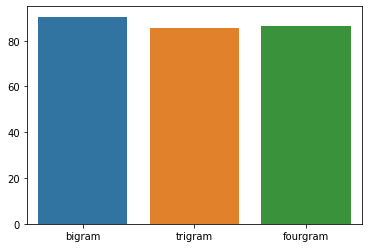

In [82]:
keys = list(one_edit_distance_ngram_accuracies.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(one_edit_distance_ngram_accuracies[k]) for k in keys]
sns.barplot(x=keys, y=vals, );

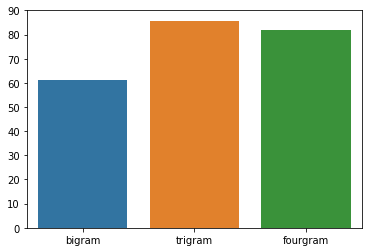

In [79]:
keys = list(two_edit_distance_ngram_accuracies.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(two_edit_distance_ngram_accuracies[k]) for k in keys]
sns.barplot(x=keys, y=vals);

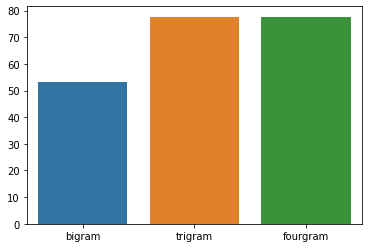

In [80]:
keys = list(three_edit_distance_ngram_accuracies.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(three_edit_distance_ngram_accuracies[k]) for k in keys]
sns.barplot(x=keys, y=vals);

# test on bigrams

In [35]:
bigram_homophonic_df=pd.read_csv("homophonics bigram.csv", index_col=[0])
bigram_random_error_df=pd.read_csv("random bigram.csv", index_col=[0])
bigram_random_error_df.sample(n=10)

,correct word,misspelled word,total edit distance,number of words with error,close change,changes,none word
2251,چشم می‌خورد,چسشم می‌خوذد,2.0,2.0,1.0,"[[2], [0]]",True
1682,مورد نظر,مولرد نظر,1.0,1.0,0.0,"[[2], []]",True
2018,دستگیر شدند,دنستگیر شدند,1.0,1.0,0.0,"[[2], []]",True
2646,کمیسیون اقتصادی,کمیسیون اقتصدطی,2.0,1.0,0.0,"[[], [1, 2]]",True
287,برگزاری انتخابات,برگرززی انتخابات,3.0,1.0,1.0,"[[2, 1, 0], []]",True
1468,اما نکته,تاما نته,2.0,2.0,1.0,"[[2], [1]]",True
2454,تومان رسید,یومان ضرسیش,3.0,2.0,0.0,"[[0], [2, 0]]",True
744,به‌گزارش همشهری,بخ‌گزار همشهرب,3.0,2.0,1.0,"[[0, 1], [0]]",True
32,وزیر بهداشت,وزطا بهداشت,2.0,1.0,0.0,"[[0, 0], []]",True
2627,بازی‌های المپیک,بازی‌حهی المپیک,2.0,1.0,1.0,"[[2, 1], []]",True


In [36]:
%%time
# sample_df = random_error_df.query("`total edit distance`==1").sample(200).reset_index(drop=True)
bigram_random_error_sample_df = bigram_random_error_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, bigram_random_error_sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.9366666666666666 0.9477234401349073
Wall time: 1min 4s


In [138]:
%%time
bigram_homophonic_error_sample_df = bigram_homophonic_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, bigram_homophonic_error_sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.8990276738967838 0.900374531835206
Wall time: 2min 2s


In [172]:
%%time
# sample_df = random_error_df.query("`total edit distance`==2").sample(200).reset_index(drop=True)
bigram_random_error_sample_df2 = bigram_random_error_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, bigram_random_error_sample_df2, save_time=True)
print(accuracy, non_empty_accuracy)

0.575503355704698 0.5893470790378007
Wall time: 4min 11s


In [122]:
%%time
# sample_df = homophonic_df.query("`total edit distance`==2").sample(200).reset_index(drop=True)
bigram_homophonic_error_sample_df2 = bigram_homophonic_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, bigram_homophonic_error_sample_df2, save_time=True)
print(accuracy, non_empty_accuracy)
# 8 min

0.5995828988529719 0.7334183673469388
Wall time: 11min 10s


In [173]:
%%time
# sample_df = random_error_df.query("`total edit distance`==3").sample(200).reset_index(drop=True)
bigram_random_error_sample_df3 = bigram_random_error_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, bigram_random_error_sample_df3, save_time=True)
print(accuracy, non_empty_accuracy)
# 52 accuracy i think

0.5068143100511073 0.5293594306049823
Wall time: 5min 3s


In [84]:
%%time
# sample_df = homophonic_df.query("`total edit distance`==3").sample(200).reset_index(drop=True)
bigram_homophonic_error_sample_df3 = bigram_homophonic_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, bigram_homophonic_error_sample_df3, save_time=True)
print(accuracy, non_empty_accuracy)

0.5162907268170426 0.6688311688311688
Wall time: 4min 4s


# test on threegrams

In [178]:
# homophonic_df=pd.read_csv("homophonics threeword.csv", index_col=[0])
threegram_random_error_df=pd.read_csv("random threegram.csv", index_col=[0])
threegram_random_error_df.sample(n=10)

,correct word,misspelled word,total edit distance,number of words with error,close change,changes,none word
569,مدیریت بحران شهر,مدیریت بحران ثشهر,1.0,1.0,0.0,"[[], [], [2]]",True
1108,هر دو تیم,هر دو آی,2.0,1.0,1.0,"[[], [], [0, 1]]",False
2390,توجه داشته باشید,توجعه داشته یشید,3.0,2.0,1.0,"[[2], [], [0, 1]]",True
164,کمیته ملی المپیک,کمیته لی لمپیک,2.0,2.0,1.0,"[[], [1], [1]]",True
2188,هزار تومان رسید,زلر تومان رسید,2.0,1.0,1.0,"[[1, 0], [], []]",False
87,شاخص کل بورس,شل کل بورس,3.0,1.0,1.0,"[[0, 1, 1], [], []]",False
1671,حجت‌الاسلام والمسلمین محسنی,حجت‌الاسلام والمسلمسن محسنی,1.0,1.0,1.0,"[[], [0], []]",True
2535,افزایش پایه پولی,افزایش پیه پدلی,2.0,2.0,1.0,"[[], [1], [0]]",True
2889,بازی‌های پارالمپیک توکیو,بازی‌های پوارالمپیک توکیو,1.0,1.0,0.0,"[[], [2], []]",True
2683,بنیاد مسکن انقلاب,بنیاد مشسمن انقلاب,2.0,1.0,1.0,"[[], [2, 0], []]",True


In [180]:
len(threegram_random_error_sample_df)

599

In [179]:
%%time
threegram_random_error_sample_df = threegram_random_error_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres, times = test_spell_checker(SP, threegram_random_error_sample_df, save_time=True, return_times=True)
print(accuracy, non_empty_accuracy)
# 10 mins

0.9532554257095158 0.9794168096054888
Wall time: 10min 45s


In [119]:
%%time
threegram_random_error_sample_df2 = threegram_random_error_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, threegram_random_error_sample_df2, save_time=True)
print(accuracy, non_empty_accuracy)
# 14 mins

0.9172240802675585 0.9273034657650042
Wall time: 14min 21s


In [120]:
%%time
threegram_random_error_sample_df3 = threegram_random_error_df.query("`total edit distance`==3").reset_index(drop=True)
threegram_random_error_accuracy3, threegram_random_error_non_empty_accuracy3, threegram_random_error_answeres3 = test_spell_checker(SP, threegram_random_error_sample_df3, save_time=True)
print(threegram_random_error_accuracy3, threegram_random_error_non_empty_accuracy3)
# 14 mins

0.8175675675675675 0.8266438941076003
Wall time: 14min 9s


# test on fourgrams

In [265]:
# homophonic_df=pd.read_csv("homophonics threeword.csv", index_col=[0])
fourgram_random_error_df=pd.read_csv("random fourgram.csv", index_col=[0])
fourgram_random_error_df.sample(n=10)

,correct word,misspelled word,total edit distance,number of words with error,close change,changes,none word
514,آیین‌نامه داخلی مجلس شورای,آیبن‌تامه داخلی مچجلس شورای,3.0,2.0,1.0,"[[0, 0], [], [2], []]",True
242,گزارش پایگاه اطلاع‌رسانی ریاست‌جمهوری,گزارش پایگاه اطاع‌رسشزی ریاست‌جمهوری,3.0,1.0,0.0,"[[], [], [1, 0, 0], []]",True
1605,شورای امنیت ملی آمریکا,شورای امنیت می تمریکا,2.0,2.0,1.0,"[[], [], [1], [0]]",True
483,میلیارد تومان کسری بودجه,میلیارد تومان کسسری بجه,3.0,2.0,0.0,"[[], [], [2], [1, 1]]",True
850,حاج قاسم سلیمانی فرمانده,حاج قاسم سلبینتانی فرمانده,3.0,1.0,1.0,"[[], [], [2, 0, 2], []]",True
907,جلسه دیروز شورای عالی,لسه دیروز شورای غعالی,2.0,2.0,1.0,"[[1], [], [], [2]]",True
1698,وبگاه ورلد امترز نشان,بگانه ورلد امترز نشوان,3.0,2.0,0.0,"[[1, 2], [], [], [2]]",True
1096,امام حسن عسکری ع,امام حسن عسکر نع,2.0,2.0,0.0,"[[], [], [1], [2]]",False
2457,آینده‌ای نه چندان دور,آینده‌ای نپه چنان دور,2.0,2.0,0.0,"[[], [2], [1], []]",True
80,اجرای سیاست‌های کلی اصل,اجرای سیاست‌های کفلی اصل,1.0,1.0,0.0,"[[], [], [2], []]",True


In [90]:
%%time
fourgram_random_error_sample_df = fourgram_random_error_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, fourgram_random_error_sample_df, save_time=True)
print(accuracy, non_empty_accuracy)
# 35 min

0.7796327212020033 0.9769874476987448
Wall time: 32min 35s


In [91]:
%%time
fourgram_random_error_sample_df2 = fourgram_random_error_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, fourgram_random_error_sample_df2, save_time=True)
print(accuracy, non_empty_accuracy)
# 55 min

0.8309623430962343 0.9697265625
Wall time: 53min 57s


In [92]:
%%time
fourgram_random_error_sample_df3 = fourgram_random_error_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, fourgram_random_error_sample_df3, save_time=True)
print(accuracy, non_empty_accuracy)

0.8170320404721754 0.9518664047151277
Wall time: 50min 58s


# faSpell

In [24]:
faSpell_df=pd.read_csv("faspell_main.csv").reset_index(drop=True)
faSpell_df.sample(n=10)

,#misspelt,corrected,error-category
3480,معرز,معرض,1
440,انچه,آنچه,1
2475,شيبار,شيار,1
1276,تون,توان,1
1507,خاسیت,خاصیت,1
2805,فرمان بران,فرمانبران,0
2998,كاررفته,كار رفته,2
4255,وتحليل,و تحليل,2
2936,قزه,غزه,1
683,برا ي,براي,0


In [54]:
corrects = 0
empties = 1
answeres = []
for i in range(len(faSpell_df)):
    correct_word, misspelled_word = faSpell_df.loc[i, ["corrected", "#misspelt"]]
    try:
#            print(correct_word, "---", misspelled_word)
        corrected_word = SP.correct_answere(misspelled_word, save_time=True)
        if corrected_word == "":
            empties += 1
    except Exception as e:
        print(correct_word)
        print(misspelled_word)
        print(len(correct_word), len(misspelled_word))
        raise Exception()
    answeres.append(corrected_word)
    if corrected_word == correct_word:
        corrects += 1
#         print("*****")

In [57]:
print(corrects/len(faSpell_df), corrects/(len(faSpell_df)-empties))

0.11568546727048168 0.12249346120313863


# statistics

In [124]:
word2vec_model.wv.vectors.shape

(347679, 300)

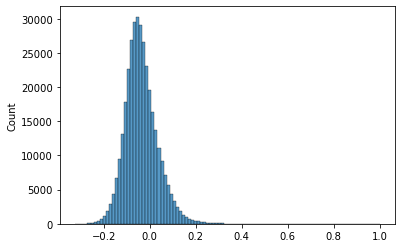

In [134]:
sns.histplot(x=word2vec_model.wv.cosine_similarities(word2vec_model.wv["سازمان"], word2vec_model.wv.vectors), bins=100);

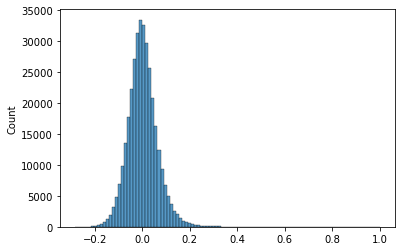

In [149]:
sns.histplot(x=word2vec_model.wv.cosine_similarities(word2vec_model.wv["غذا"], word2vec_model.wv.vectors), bins=100);

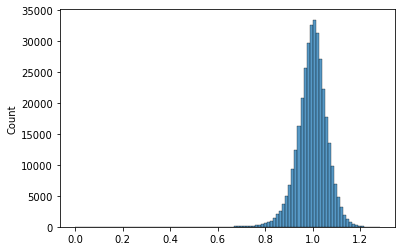

In [148]:
sns.histplot(x=word2vec_model.wv.distances("غذا", other_words=([key for key in word2vec_model.wv.key_to_index])), bins=100);

In [183]:
sum(word2vec_model.wv.distances("غذا", other_words=([key for key in word2vec_model.wv.key_to_index])) < 0.9)

20137

In [187]:
for key in word2vec_model.wv.key_to_index:
    sim = word2vec_model.wv.cosine_similarities(word2vec_model.wv["غذا"], [word2vec_model.wv[key]])
    if sim > 0.35 and sim < 0.4:
        print(key)

ملل
دارویی
شیر
خوراک
چای
تغذیه
خوراکی
داروها
سرم
گرسنگی
بسته‌بندی
مایحتاج
افطار
دستکش
خرما
غذاهای
آشپزخانه
پلاستیک
شوینده
آجیل
ضدعفونی‌کننده
لقمه
شستن
شربت
شیرخشک
میوه‌ها
سبزیجات
پودر
پز
پلاسما
پوشک
برنامه‌وبودجه
محلول
خوابیدن
کنسرو
نوشابه
دستشویی
آمپول
بستنی
صابون
نانی
سحری
شکلات
آبگوشت
مکمل‌های
قرص‌های
نوشیدنی‌های
خوشمزه
طعام
داروست
تنقلات
جیره
ساندویچ
ویتامین‌ها
بشقاب
سالاد
پخت‌وپز
دورریز
چیپس
غذا‌های
نظام‌پزشکی
سوپ
ملل‌بود
نوشیدنی‌ها
دمنوش
لذیذ
دسفرال
می‌پزند
خوراندن
دارو‌بود
غذاودارو
بپزد
می‌پزد
مقوی
چاشت
میان‌وعده
مللی
بپزند
ملل‌متحد
پریمیدون
نمی‌شویند
آدوکانوماب
سیا‌بودم
بخورین
لکت
ویسواگوارو
سه‌ربع
نصرکشور
اوقاف‌بود
آب‌و‌فاضلاب
دیگ‌دیگ
میراث‌فرهنگی‌بودید
محلی‌ترین
تهرانسره
امور‌مالیاتی
مریضامون
رسمی‌مقامات
فرآیند‌‌های
تجویز‌شده‌اما
